# Calculating hourly demand

In [137]:
from pandas import DataFrame, read_csv
import datetime
import math
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import pylab
from scipy.optimize import curve_fit
import os

## Generate Dateframe for hourly heat demand

In [138]:
date_rng = pd.date_range(start='1/1/2012 01:00:00', end='01/01/2019', freq='H') 
Hourly_heat_demand = pd.DataFrame(date_rng, columns=['Date'])
Hourly_heat_demand['Date'] = Hourly_heat_demand['Date'].apply(lambda x: x - pd.DateOffset(minutes=1))
len(Hourly_heat_demand.index)

61368

In [139]:
Hourly_heat_demand['Index Date'] = pd.to_datetime(Hourly_heat_demand['Date'], format='%Y%m%d %H:%M:%S')
#Hourly_heat_demand.set_index('Index Date', inplace=True)
Hourly_heat_demand.reset_index(drop=True);
len(Hourly_heat_demand.index)

61368

## Read data from sigmoid modelling

In [140]:
# read the effective temperature data and specific gas demand
# parse the column Date - otherwise Bokeh cannot read the data more info here
# https://stackoverflow.com/questions/54021664/bokeh-columndatasource-line-not-rendering?answertab=votes#tab-top
file = "KNMI_Teff_1965_2018_spec.csv"
KNMI_Teff = pd.read_csv(file, header=0, parse_dates=["Date"])

In [141]:
KNMI_Teff['Index Date'] = KNMI_Teff['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
#Hourly_heat_demand['Index Date'] = Hourly_heat_demand['Index Date'].apply(lambda x: x - pd.DateOffset(minutes=1))
KNMI_Teff.set_index('Index Date', inplace=True)
KNMI_Teff.reset_index(drop=True);

In [142]:
len(KNMI_Teff.index)

19706

### Use only subset of years 2012-2018

In [143]:
# copy only year 2012 - 2018 into new data frame
KNMI_Teff_2012_2018 = pd.DataFrame(KNMI_Teff.loc['2012-01-01':'2018-12-31'])

In [144]:
KNMI_Teff_2012_2018['Gas_demand_specific'].sum()

7.112821078651798

In [145]:
len(KNMI_Teff_2012_2018.index)

2557

## Create day, month, year columns for search

In [146]:
KNMI_Teff_2012_2018['Day'] = KNMI_Teff_2012_2018.Date.dt.day
KNMI_Teff_2012_2018['Month'] = KNMI_Teff_2012_2018.Date.dt.month
KNMI_Teff_2012_2018['Year'] = KNMI_Teff_2012_2018.Date.dt.year

Hourly_heat_demand['Hour'] = Hourly_heat_demand.Date.dt.hour
Hourly_heat_demand['Day'] = Hourly_heat_demand.Date.dt.day
Hourly_heat_demand['Month'] = Hourly_heat_demand.Date.dt.month
Hourly_heat_demand['Year'] = Hourly_heat_demand.Date.dt.year

In [147]:
# note: merge database only by selected fields by using: KNMI_Teff_2012_2018[['Year', 'Month','Day','Gas_demand_specific']]
Hourly_heat_demand = Hourly_heat_demand.merge(KNMI_Teff_2012_2018[['Year', 'Month','Day','Gas_demand_specific']], \
                         how='inner', on=['Year' , 'Month', 'Day']);

In [148]:
Hourly_heat_demand

,Date,Index Date,Hour,Day,Month,Year,Gas_demand_specific
0,2012-01-01 00:59:00,2012-01-01 00:59:00,0,1,1,2012,0.003711
1,2012-01-01 01:59:00,2012-01-01 01:59:00,1,1,1,2012,0.003711
2,2012-01-01 02:59:00,2012-01-01 02:59:00,2,1,1,2012,0.003711
3,2012-01-01 03:59:00,2012-01-01 03:59:00,3,1,1,2012,0.003711
4,2012-01-01 04:59:00,2012-01-01 04:59:00,4,1,1,2012,0.003711
5,2012-01-01 05:59:00,2012-01-01 05:59:00,5,1,1,2012,0.003711
6,2012-01-01 06:59:00,2012-01-01 06:59:00,6,1,1,2012,0.003711
7,2012-01-01 07:59:00,2012-01-01 07:59:00,7,1,1,2012,0.003711
8,2012-01-01 08:59:00,2012-01-01 08:59:00,8,1,1,2012,0.003711
9,2012-01-01 09:59:00,2012-01-01 09:59:00,9,1,1,2012,0.003711


In [149]:
len(Hourly_heat_demand.index)

61368

In [150]:
Hourly_heat_demand['Gas_demand_specific'].sum()

170.70770588764316

In [151]:
file = "Liander_gas_day_spec.csv"
Liander_gas_day_spec = pd.read_csv(file, header=0, parse_dates=['Date'])
#Liander_gas_day_spec['Date']=Liander_gas_day_spec['New Date']
Liander_gas_day_spec['New Date'] = Liander_gas_day_spec['New Date'].apply(lambda x: \
                                                                          pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))

In [152]:
Liander_gas_day_spec['Uur fractie G'].sum()

1.00000001188

In [153]:
Liander_gas_day_spec['Dag fractie G'].sum()

24.000000285120002

In [154]:
Liander_gas_day_spec['Hour'] = Liander_gas_day_spec['New Date'].dt.hour
Liander_gas_day_spec['Day'] = Liander_gas_day_spec['New Date'].dt.day
Liander_gas_day_spec['Month'] = Liander_gas_day_spec['New Date'].dt.month
Liander_gas_day_spec['Year'] = Liander_gas_day_spec['New Date'].dt.year

In [156]:
Liander_gas_day_spec

,Date,Dag,G1a profiled demand [MJ],G2a profiled demand [MJ],Totaal,Uur fractie G,New Date,Dag fractie G,Hour,Day,Month,Year
0,2008-01-01 01:00:00,1.0,0.000082,0.000179,0.000261,0.000102,2008-01-01 00:59:00,0.005258,0,1,1,2008
1,2008-01-01 02:00:00,1.0,0.000076,0.000195,0.000271,0.000106,2008-01-01 01:59:00,0.005258,1,1,1,2008
2,2008-01-01 03:00:00,1.0,0.000084,0.000208,0.000291,0.000114,2008-01-01 02:59:00,0.005258,2,1,1,2008
3,2008-01-01 04:00:00,1.0,0.000095,0.000229,0.000324,0.000127,2008-01-01 03:59:00,0.005258,3,1,1,2008
4,2008-01-01 05:00:00,1.0,0.000117,0.000259,0.000376,0.000147,2008-01-01 04:59:00,0.005258,4,1,1,2008
5,2008-01-01 06:00:00,1.0,0.000176,0.000308,0.000484,0.000189,2008-01-01 05:59:00,0.005258,5,1,1,2008
6,2008-01-01 07:00:00,1.0,0.000320,0.000379,0.000699,0.000273,2008-01-01 06:59:00,0.005258,6,1,1,2008
7,2008-01-01 08:00:00,1.0,0.000401,0.000441,0.000841,0.000329,2008-01-01 07:59:00,0.005258,7,1,1,2008
8,2008-01-01 09:00:00,1.0,0.000397,0.000440,0.000837,0.000327,2008-01-01 08:59:00,0.005258,8,1,1,2008
9,2008-01-01 10:00:00,1.0,0.000367,0.000415,0.000782,0.000306,2008-01-01 09:59:00,0.005258,9,1,1,2008


In [157]:
len(Liander_gas_day_spec.index)

8784

In [161]:
# note: merge database only by selected fields by using: KNMI_Teff_2012_2018[['Year', 'Month','Day','Gas_demand_specific']]
Hourly_heat_demand = Hourly_heat_demand.merge\
                     (Liander_gas_day_spec[['Month','Day', 'Hour', 'Uur fractie G', 'Dag fractie G']],\
                      how='left', on=[ 'Month', 'Day', 'Hour'])

In [163]:
Hourly_heat_demand

,Date,Index Date,Hour,Day,Month,Year,Gas_demand_specific,Uur fractie G,Dag fractie G
0,2012-01-01 00:59:00,2012-01-01 00:59:00,0,1,1,2012,0.003711,0.000102,0.005258
1,2012-01-01 01:59:00,2012-01-01 01:59:00,1,1,1,2012,0.003711,0.000106,0.005258
2,2012-01-01 02:59:00,2012-01-01 02:59:00,2,1,1,2012,0.003711,0.000114,0.005258
3,2012-01-01 03:59:00,2012-01-01 03:59:00,3,1,1,2012,0.003711,0.000127,0.005258
4,2012-01-01 04:59:00,2012-01-01 04:59:00,4,1,1,2012,0.003711,0.000147,0.005258
5,2012-01-01 05:59:00,2012-01-01 05:59:00,5,1,1,2012,0.003711,0.000189,0.005258
6,2012-01-01 06:59:00,2012-01-01 06:59:00,6,1,1,2012,0.003711,0.000273,0.005258
7,2012-01-01 07:59:00,2012-01-01 07:59:00,7,1,1,2012,0.003711,0.000329,0.005258
8,2012-01-01 08:59:00,2012-01-01 08:59:00,8,1,1,2012,0.003711,0.000327,0.005258
9,2012-01-01 09:59:00,2012-01-01 09:59:00,9,1,1,2012,0.003711,0.000306,0.005258


In [164]:
len(Hourly_heat_demand.index)

61368

In [165]:
Hourly_heat_demand['Uur fractie G'].sum()

6.97490793266

In [166]:
#Hourly_heat_demand.describe()
Hourly_heat_demand.groupby([Hourly_heat_demand['Date'].dt.month,Hourly_heat_demand['Date'].dt.day])['Uur fractie G']

In [167]:
Hourly_heat_demand['Gas demand'] = (Hourly_heat_demand['Uur fractie G']) * (Hourly_heat_demand['Gas_demand_specific'] / Hourly_heat_demand['Dag fractie G'])

In [168]:
Hourly_heat_demand.loc[Hourly_heat_demand['Year'] == 2017, 'Gas demand'].sum()
#Hourly_heat_demand['Gas demand'].sum()

1.0000000013936636

In [169]:
Hourly_heat_demand['Gas demand'].sum()

7.112821078651799

In [170]:
Hourly_heat_demand['Uur fractie G'].sum()

6.97490793266

In [171]:
Hourly_heat_demand.groupby(["Year"])["Gas demand"].sum()

Year
2012    1.067640
2013    1.138635
2014    0.893496
2015    0.984056
2016    1.035785
2017    1.000000
2018    0.993209
Name: Gas demand, dtype: float64

In [172]:
Hourly_heat_demand.groupby(["Year"])["Dag fractie G"].sum()

Year
2012    24.000000
2013    23.879558
2014    23.879558
2015    23.879558
2016    24.000000
2017    23.879558
2018    23.879558
Name: Dag fractie G, dtype: float64

In [173]:
Hourly_heat_demand.groupby(["Year"])["Gas_demand_specific"].sum()

Year
2012    25.623367
2013    27.327242
2014    21.443911
2015    23.617334
2016    24.858836
2017    24.000000
2018    23.837017
Name: Gas_demand_specific, dtype: float64

In [174]:
y_data = Hourly_heat_demand['Gas demand'] * 1200.0
y_data.sum()
#Hourly_heat_demand.plot(x='Date', y_data)

8535.385294382158

In [175]:
Hourly_heat_demand.loc[(Hourly_heat_demand['Year'] == 2017) & \
                       (Hourly_heat_demand['Month'] == 10) & \
                       (Hourly_heat_demand['Day'] == 8), \
                       ['Date', 'Uur fractie G', 'Gas demand', 'Dag fractie G', 'Gas_demand_specific']]

,Date,Uur fractie G,Gas demand,Dag fractie G,Gas_demand_specific
50568,2017-10-08 00:59:00,0.000037,0.000037,0.002025,0.00206
50569,2017-10-08 01:59:00,0.000039,0.000039,0.002025,0.00206
50570,2017-10-08 02:59:00,0.000043,0.000044,0.002025,0.00206
50571,2017-10-08 03:59:00,0.000051,0.000052,0.002025,0.00206
50572,2017-10-08 04:59:00,0.000073,0.000075,0.002025,0.00206
50573,2017-10-08 05:59:00,0.000122,0.000124,0.002025,0.00206
50574,2017-10-08 06:59:00,0.000145,0.000148,0.002025,0.00206
50575,2017-10-08 07:59:00,0.000142,0.000145,0.002025,0.00206
50576,2017-10-08 08:59:00,0.000124,0.000126,0.002025,0.00206
50577,2017-10-08 09:59:00,0.000109,0.000111,0.002025,0.00206


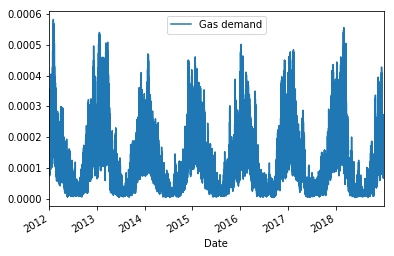

In [176]:
Hourly_heat_demand.set_index('Date', inplace=True)
Hourly_heat_demand.plot(y='Gas demand')

In [177]:
Hourly_heat_demand.reset_index(inplace=True)
file = "Paddepoel_Gas_demand_2012_2018.csv"
header = ["Date", "Gas demand"]
Hourly_heat_demand.to_csv(file, columns = header, date_format='%Y-%m-%d %H:%M:%S', index=False)

In [179]:
len(Hourly_heat_demand.index)

61368